# Importing Batteries

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import statsmodels.api as sm
import sklearn as sk
import sklearn.linear_model as lm

import sklearn.model_selection as split
from sklearn.pipeline import Pipeline


/Users/jeroenderyck/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Styling purpose
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("talk")

# Manual Reload Classes

In [34]:
import Credit_risk_classes as Classes


In [33]:
from importlib import reload
reload(Classes)

<module 'Credit_risk_classes' from '/Users/jeroenderyck/Documents/Credit Models/Credit_risk_classes.py'>

### Load in Raw Datafile

In [7]:
# Processing will have to be in python
data_raw=pd.read_csv("/Users/jeroenderyck/Documents/Data/CreditRiskModels/Credit_DATA.csv",index_col=0)

/Users/jeroenderyck/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


#### Loans with only one observation are deleted from sample
### DISCLAIMER : Optional

In [8]:
# --> clean loans with only one observation
#DF is dataframe of raw dataset
data_raw=data_raw[data_raw.groupby("masterloanidtrepp")["observation_date"].transform("count")>1]


# RENAMING.
### 1. Checked Data Dictionary for corresponding names. 
### 2. we only choose one appraisal value and look at percentage changes such that we dont need priors 

In [9]:
#Imputations
data = (data_raw
    .rename(columns={
        "bad_flag_final_v3":"Target_Response",
        'appvalue': 'pure_appraisal',
        'fmrappvalue': 'total_value_property',
        'gr_appvalue': 'pure_appraisal_Growth',
        'obal': 'outstanding_scheduled_balance',
        'origloanbal': 'original_loan_balance',
        'mrfytdocc': 'percentage_occupied_rentspace',
        'oltv': 'origination_loan_to_value',
        'oterm': 'original_maturity',
        'priorfyncf': 'most_recent_ncf',
        'priorfydscrncf': 'recent_ncf_ratio_debtservice',
        'priorfynoi': 'recent_noi',
        'priorfyocc': 'recent_fiscal_occupied_rentspace',
        'priorfydscr': 'most_recent_fiscal_debt_service',
        'cltv_1': 'current_loan_to_value_indexed'
    })
    .drop(["appvalue_prior","mrappvalue","gr_mrappvalue","sample","changeinvalue","balact","gr_balact"
        ,"msa"], axis=1)
)



## Missing Values Ranking 
 -Rentarea and Units need to be imputed
 -if less than 1% missing --> can use mean and median

In [11]:
Classes.rank_nan(data)

units                               0.533306
rentarea                            0.450721
percentage_occupied_rentspace       0.450238
recent_ncf_ratio_debtservice        0.299966
most_recent_ncf                     0.298894
recent_fiscal_occupied_rentspace    0.281603
current_loan_to_value_indexed       0.262452
most_recent_fiscal_debt_service     0.233555
recent_noi                          0.226928
debt_yield_p1                       0.186695
pure_appraisal_Growth               0.039985
original_loan_balance               0.036647
balact_prior                        0.033695
securappvalue                       0.012614
securltv                            0.005727
origination_loan_to_value           0.005727
pure_appraisal                      0.005449
total_value_property                0.005222
corrected_ttm_months                0.000000
Target_Response                     0.000000
observation_date                    0.000000
year                                0.000000
outstandin

# Splitting the data.     

1. __Training Versus Test set__  
In order to test our models, we will need to divide the dataset in a training and test set.
However we would like to keep loans in the same set, such that for example loan A belongs in the training set and loan B in the test set.        


2. __Data splitter__
The $DataSplitter$ class works like this. You give in the data and the target that needs to be classified predicted.  
Addtionally you give in the group variable for Panel data
It returns Datasplitter instance with attributes :
  - Training_X
  - Training_Y
  - Testing_X
  - Testing_Y
  - Training_names = list with names of loans that belong in training set
  - Testing names

In [21]:
Data_Splitter=Classes.Data_Splitter(data,Target="Target_Response",
                                    fraction_training=0.8,Group_variable="masterloanidtrepp")


In [22]:
Training_X,Training_Y= Data_Splitter.X_Training, Data_Splitter.Y_Training
Testing_X, Testing_Y = Data_Splitter.X_Testing ,Data_Splitter.Y_Testing

## Linear Imputation
We notice that $units$ and $rentarea$  must be closely related. We can impute them through a linear relationship


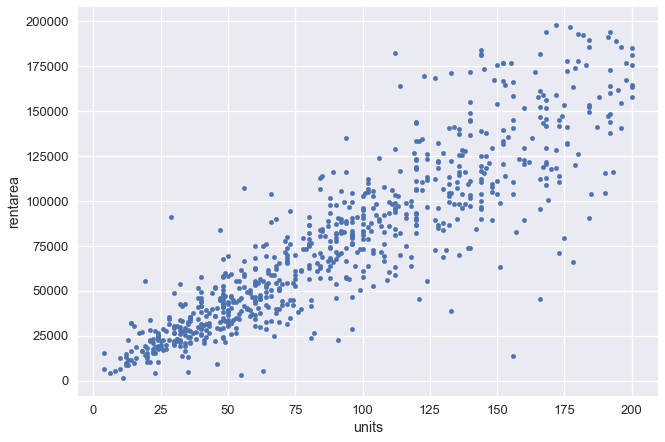

In [14]:
(data[
    ["units","rentarea"]]
    .drop_duplicates().dropna()
    .query(" units <= 200")
    .query("1000 <= rentarea <= 200000")
    .plot(kind="scatter",x="units",y="rentarea")
)

In [38]:
data[["units"]].isnull().sum()

units    0
dtype: int64

In [35]:
#Check results#Impute Units
data =(Classes.Imputer(data)
            .impute_linear_model(target_column="units",
                                 training_frame=Data_Splitter.X_Training,
                                 independent_variable="rentarea",
                                 intercept=False,
                                 )
      )
# Impute Rentarea
data =(Classes.Imputer(data)
            .impute_linear_model(target_column  = "rentarea",
                                 training_frame = Data_Splitter.X_Training,
                                 independent_variable = "units",
                                 intercept=False
                                 )
      )

#Check results
Classes.rank_nan(data).head(10)

NotImplementedError: 

1. Impute $Original loan balance$ by median.       

2. Impute $Pure apraisal growth$  by mean.  
3. Create change in $Pure-$ and $Total appraisal$ as a new feauture

In [ ]:
Classes.impute_med

In [39]:
# Fill original  loan balance with median of group loan
#fill pure appraisal growth with mean of group loan
data=Classes.impute_median(data,"original_loan_balance",Group_variable="masterloanidtrepp")
data=Classes.impute_mean(data,"pure_appraisal_Growth",Group_variable="masterloanidtrepp")
data= Classes.impute_mean(data,"recent_ncf_ratio_debtservice",Group_variable="masterloanidtrepp")
# Changes Pure and total Appraisal 
data=data.assign(Change__pure_appraisal=lambda x: x.groupby("masterloanidtrepp")["pure_appraisal"].pct_change())
data=data.assign(Change_total_appraisal=lambda x: x.groupby("masterloanidtrepp")["total_value_property"].pct_change())

## Imputing original Loan Balance --> proxy original 

By the definition of the origination loan to value ratio we can extract the original loan balance:  

$$OriginationLoanToValue=\frac{OriginalLoanBalance}{Original AppraisalValue}$$


$$OriginationLoanToValue \times Original AppraisalValue=OriginalLoanBalance$$


In [40]:
#Check if origination loan to value makes sense with original appraisal value
data_mortgage_values=data.groupby("masterloanidtrepp")["pure_appraisal"].first()*data.groupby("masterloanidtrepp"
                                                            )["origination_loan_to_value"].first()/100

data_mortgage = pd.DataFrame(data_mortgage_values,columns=["original_mortgage_value"])

# differences are not that big we add  a column to our dataframe because this one has no NAN
if "original_mortgage_value" in data.columns:
    pass
else:
    data= data.join(data_mortgage[["original_mortgage_value"]],on="masterloanidtrepp",how="left")


Median_original_mortgage =  data["original_mortgage_value"].median()
data=data.assign(original_mortgage_value=data["original_mortgage_value"].fillna(Median_original_mortgage).values)
    

# Seaborn Pairplots

In [42]:
Classes.rank_nan(data).head(10)

percentage_occupied_rentspace       0.450238
most_recent_ncf                     0.298894
recent_fiscal_occupied_rentspace    0.281603
current_loan_to_value_indexed       0.262452
most_recent_fiscal_debt_service     0.233555
recent_noi                          0.226928
debt_yield_p1                       0.186695
Change__pure_appraisal              0.039363
Change_total_appraisal              0.039138
balact_prior                        0.033695
dtype: float64

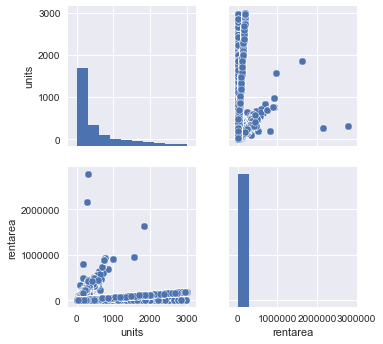

In [51]:
data_relationship_plot=(data[["units","rentarea"]]
                       .query("units <= 3000"))
                       


sns.set()
sns.pairplot(data_relationship_plot)

# Fancy Impute

In [43]:
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute


In [44]:
cols_to_transform = [ 'maturitytype', 'rateindex', 'segment_2', 'segment_1_new','division','interestonly']


In [45]:
data_for_imputation= pd.get_dummies(data=data,columns=cols_to_transform).drop("observation_date",axis=1)


In [46]:
data_filled_soft =SoftImpute().complete(data_for_imputation)

[SoftImpute] Max Singular Value of X_init = 152776072824.215668
[SoftImpute] Iter 1: observed MAE=129037.392223 rank=8
[SoftImpute] Iter 2: observed MAE=128101.352269 rank=8
[SoftImpute] Iter 3: observed MAE=128008.952880 rank=8
[SoftImpute] Iter 4: observed MAE=127990.403668 rank=8
[SoftImpute] Iter 5: observed MAE=127981.130654 rank=8
[SoftImpute] Iter 6: observed MAE=127973.682516 rank=8
[SoftImpute] Iter 7: observed MAE=127966.723564 rank=8
[SoftImpute] Iter 8: observed MAE=127960.790980 rank=8
[SoftImpute] Iter 9: observed MAE=127956.135212 rank=8
[SoftImpute] Iter 10: observed MAE=127952.766274 rank=8
[SoftImpute] Iter 11: observed MAE=127950.318954 rank=8
[SoftImpute] Iter 12: observed MAE=127948.533024 rank=8
[SoftImpute] Iter 13: observed MAE=127947.241886 rank=8
[SoftImpute] Iter 14: observed MAE=127946.273896 rank=8
[SoftImpute] Iter 15: observed MAE=127945.532359 rank=8
[SoftImpute] Iter 16: observed MAE=127944.945077 rank=8
[SoftImpute] Iter 17: observed MAE=127944.472031 

In [49]:
data_imputed = pd.DataFrame(data=data_filled_soft,columns=data_for_imputation.columns,index=data_for_imputation.index)

In [51]:
data_imputed.to_csv("/Users/jeroenderyck/Desktop/Credit_Risk_Imputed")

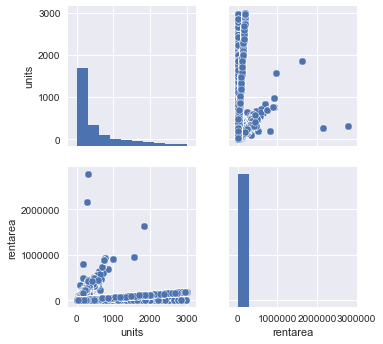

In [53]:
data_relationship_plot=(data[["units","rentarea","rateindex"]]
                       .query("units <= 3000"))
                       


sns.set()
sns.pairplot(data_relationship_plot,hue="rateindex")

In [ ]:
original_mortgage_value

In [ ]:
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute

# X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN

# Use 3 nearest rows which have a feature to fill in each row's missing features
data_filled_knn = KNN(k=3).complete(data)

# matrix completion using convex optimization to find low-rank solution
# that still matches observed values. Slow!
data_filled_nnm = NuclearNormMinimization().complete(data)

# Instead of solving the nuclear norm objective directly, instead
# induce sparsity using singular value thresholding
data_filled_softimpute = SoftImpute().complete(data.normalize())



In [104]:
splitter= Classes.Data_Splitter(Data=data_imputed,fraction_training=0.8,Group_variable="masterloanidtrepp")

In [143]:
Training , Test= splitter.Training_frame, splitter.Validation_frame

In [144]:
Training.head()

,masterloanidtrepp,Target_Response,pure_appraisal,balact_prior,corrected_ttm_months,total_value_property,pure_appraisal_Growth,percentage_occupied_rentspace,outstanding_scheduled_balance,origination_loan_to_value,...,division_NorthEast-NewEngland,division_Other,division_South-Atlantic,division_South-EastSouthCentral,division_South-WestSouthCentral,division_West-Mountain,division_West-Pacific,interestonly_N,interestonly_P,interestonly_Y
1,122099.0,0.0,5800000.0,2.239636e+06,285.0,3100000.0,0.071508,96.419000,3457959.12,60.14,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,122099.0,0.0,5800000.0,2.234333e+06,282.0,3100000.0,0.071508,92.000000,3448925.88,60.14,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,122099.0,0.0,3100000.0,1.213714e+06,279.0,3100000.0,0.000000,92.000000,1821866.24,60.14,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,122099.0,0.0,3100000.0,1.213483e+06,275.0,3100000.0,0.000000,1.683325,1817318.72,60.14,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,122099.0,0.0,5800000.0,0.000000e+00,272.0,5800000.0,0.870968,1.683856,1812655.58,60.14,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [145]:
Logistic = lm.LogisticRegression().fit(X=Training.drop("Target_Response",axis=1),y=Training["Target_Response"])

In [127]:
Logistic = Classes.LogisticRegressionModel().fit(Training,Response)

In [130]:
import sklearn.linear_model as lm


In [149]:
Test.colu

,masterloanidtrepp,Target_Response,pure_appraisal,balact_prior,corrected_ttm_months,total_value_property,pure_appraisal_Growth,percentage_occupied_rentspace,outstanding_scheduled_balance,origination_loan_to_value,...,division_NorthEast-NewEngland,division_Other,division_South-Atlantic,division_South-EastSouthCentral,division_South-WestSouthCentral,division_West-Mountain,division_West-Pacific,interestonly_N,interestonly_P,interestonly_Y
129,200012.0,0.0,24900000.0,1.081393e+07,280.0,24900000.0,0.000000,9.044013,16418132.66,67.13,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
130,200012.0,0.0,24900000.0,0.000000e+00,277.0,24900000.0,-0.943775,93.000000,16373928.23,67.13,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
131,200012.0,0.0,24900000.0,0.000000e+00,274.0,24900000.0,0.000000,93.000000,16324415.51,67.13,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
132,200012.0,0.0,1400000.0,0.000000e+00,271.0,1400000.0,0.000000,13.294962,16282281.43,67.13,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
133,200012.0,0.0,24900000.0,0.000000e+00,268.0,1400000.0,0.000000,93.000000,16239077.27,67.13,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
134,200012.0,0.0,24900000.0,0.000000e+00,265.0,24900000.0,16.785714,93.000000,16190538.52,67.13,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
135,200012.0,0.0,24900000.0,0.000000e+00,262.0,24900000.0,0.000000,11.109354,16140901.07,67.13,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
136,200012.0,0.0,24900000.0,0.000000e+00,259.0,24900000.0,0.000000,7.440000,16094275.51,67.13,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
137,200012.0,0.0,24900000.0,0.000000e+00,256.0,24900000.0,0.000000,11.071146,16046469.95,67.13,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
138,200012.0,0.0,24900000.0,0.000000e+00,253.0,24900000.0,0.000000,11.049621,15993268.83,67.13,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [151]:
Logistic.predict(Test.drop("Target_Response",axis=1)).mean()

0.00035086463069707491

In [ ]:
lm.LogisticRegression().fit

In [152]:
Test_Target = Test[["Target_Response"]]
Test_Target.mean()

Target_Response    0.021976
dtype: float64

In [123]:
Test[["Target_Response"]].mean()

Target_Response    0.021976
dtype: float64